In [1]:
import seaborn as sns
import folium
from geopandas import GeoSeries, GeoDataFrame
import geopandas as gpd
import pandas as pd
from shapely import Polygon, MultiPolygon, GeometryCollection, Geometry
from os.path import exists


from utils.downloads import (
    Censo,
    Nivel,
    download_malha
)
from utils.geosampa_client import get_client
from utils.geo import calc_similarity

In [2]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

# Compatibilização dos setores censitários de 2010 e 2022

Com a divulgação do Censo de 2022, precisamos avaliar e compatibilizar os dados a nível de setor censitário entre este e sua última edição, de 2010.

Para essa avaliação precisaremos, primeiramente, baixar os dados georrefenciados de cada um dos censos.

# Distritos

## Download dos dados

In [3]:
distritos10 = download_malha(Censo.CENSO_2010, Nivel.DISTRITOS)
distritos10 = distritos10[distritos10['CD_GEOCODD'].str.startswith('3550308')]
distritos10.sample(3)

INFO:root:Baixando a malha de distritos do censo de 2010 de https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/sp/sp_distritos.zip.


,ID,CD_GEOCODD,NM_DISTRIT,geometry
831,4460,355030802,ALTO DE PINHEIROS,"POLYGON ((-46.71422 -23.53528, -46.71322 -23.5..."
915,4544,355030886,VILA GUILHERME,"POLYGON ((-46.60072 -23.49197, -46.60072 -23.4..."
846,4475,355030817,CAMPO LIMPO,"POLYGON ((-46.76090 -23.61671, -46.76090 -23.6..."


In [4]:
distritos22 = download_malha(Censo.CENSO_2022, Nivel.DISTRITOS, filtro='CD_MUN == "3550308"')
distritos22.sample(3)

INFO:root:Baixando a malha de distritos do censo de 2022 de https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/malha_com_atributos/distritos/json/UF/SP/SP_Malha_Preliminar_Distrito_2022.zip.


,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,T_SETORES,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
896,3,Sudeste,35,São Paulo,3550308,São Paulo,355030866,República,261,60720,42684,42582,102,1.912235,23.032014,31174,"POLYGON ((-46.64192 -23.55543, -46.64176 -23.5..."
845,3,Sudeste,35,São Paulo,3550308,São Paulo,355030815,Campo Belo,254,71058,36679,36593,86,2.309907,12.891838,30593,"POLYGON ((-46.67219 -23.64459, -46.67205 -23.6..."
907,3,Sudeste,35,São Paulo,3550308,São Paulo,355030877,Saúde,460,128469,65598,65506,92,2.298956,12.477308,55637,"POLYGON ((-46.63834 -23.59964, -46.63907 -23.5..."


Agora, vamos conferir e compatibilizar o sistema de referências dos dois datasets.

In [5]:
distritos10.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
distritos22.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Diferente do esperado, os datasets possuem realmente sistemas de referência distintos. Vamos transpor o dataset do Censo 2022 para o mesmo sistema do Censo 2010.

In [7]:
distritos22 = distritos22.to_crs(epsg=4674)

Agora, checamos duplicidade e a quantidade de registros em cada dataset.

In [8]:
distritos10.shape

(96, 4)

In [9]:
distritos10['NM_DISTRIT'].duplicated().any()

False

In [10]:
distritos10['CD_GEOCODD'].duplicated().any()

False

In [11]:
distritos22.shape

(96, 17)

In [12]:
distritos22['NM_DIST'].duplicated().any()

False

In [13]:
distritos22['CD_DIST'].duplicated().any()

False

E checamos os tipos das colunas, em especial as colunas utilizadas como chave (`CD_GEOCODD` e `CD_DIST`) 

In [14]:
distritos10.dtypes

ID               int64
CD_GEOCODD      object
NM_DISTRIT      object
geometry      geometry
dtype: object

In [15]:
distritos22.dtypes

CD_REGIAO      object
NM_REGIAO      object
CD_UF          object
NM_UF          object
CD_MUN         object
NM_MUN         object
CD_DIST        object
NM_DIST        object
T_SETORES      object
v0001          object
v0002          object
v0003          object
v0004          object
v0005          object
v0006          object
v0007          object
geometry     geometry
dtype: object

## Cruzar codigos distritos

Avaliamos agora se os códigos se mantiveram iguais entre os dois censos.

In [16]:
distritos22['CD_DIST'].dtype

dtype('O')

In [17]:
distritos10['CD_GEOCODD'].dtype

dtype('O')

In [18]:
distritos22['CD_DIST'].str.len().unique()

array([9])

In [19]:
distritos10['CD_GEOCODD'].str.len().unique()

array([9])

In [20]:
set(distritos10['CD_GEOCODD'])-set(distritos22['CD_DIST'])

set()

In [21]:
set(distritos22['CD_DIST'])-set(distritos10['CD_GEOCODD'])

set()

E checamos se os códigos fazem referência ao distrito de mesmo nome.

In [22]:
compara_nomes = distritos22[['CD_DIST', 'NM_DIST']].merge(distritos10[['CD_GEOCODD', 'NM_DISTRIT']], left_on='CD_DIST', right_on='CD_GEOCODD')
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT
0,355030801,Água Rasa,355030801,ÁGUA RASA
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS
2,355030803,Anhanguera,355030803,ANHANGUERA
3,355030804,Aricanduva,355030804,ARICANDUVA
4,355030805,Artur Alvim,355030805,ARTUR ALVIM
...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS
92,355030893,Vila Prudente,355030893,VILA PRUDENTE
93,355030894,Vila Sônia,355030894,VILA SÔNIA
94,355030895,São Domingos,355030895,SÃO DOMINGOS


In [23]:
compara_nomes['nomes_iguais'] = compara_nomes['NM_DIST'].str.lower() == compara_nomes['NM_DISTRIT'].str.lower()
compara_nomes

,CD_DIST,NM_DIST,CD_GEOCODD,NM_DISTRIT,nomes_iguais
0,355030801,Água Rasa,355030801,ÁGUA RASA,True
1,355030802,Alto de Pinheiros,355030802,ALTO DE PINHEIROS,True
2,355030803,Anhanguera,355030803,ANHANGUERA,True
3,355030804,Aricanduva,355030804,ARICANDUVA,True
4,355030805,Artur Alvim,355030805,ARTUR ALVIM,True
...,...,...,...,...,...
91,355030892,Vila Medeiros,355030892,VILA MEDEIROS,True
92,355030893,Vila Prudente,355030893,VILA PRUDENTE,True
93,355030894,Vila Sônia,355030894,VILA SÔNIA,True
94,355030895,São Domingos,355030895,SÃO DOMINGOS,True


In [24]:
compara_nomes['nomes_iguais'].all()

True

Todos os códigos de distrito se mantiveram e todos correspondem aos mesmos nomes.

## Recorte

Para checar se os poligonos dos distritos sao idênticos, vamos realizar o recorte de um poligono pelo outro. O resultado deve ser um poligono vazio

In [25]:
distritos10 = distritos10.sort_values(by='CD_GEOCODD')

In [26]:
distritos22 = distritos22.sort_values(by='CD_DIST')

Para melhorar a performance da comparação, vamos alterar o sistema de referência para um sistema projetado.

In [27]:
distritos10 = distritos10.to_crs('EPSG:31983')
distritos22 = distritos22.to_crs('EPSG:31983')

/home/d855395/git/compatibilizacao-setores-censitarios/env/lib/python3.12/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 430 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


<Axes: >

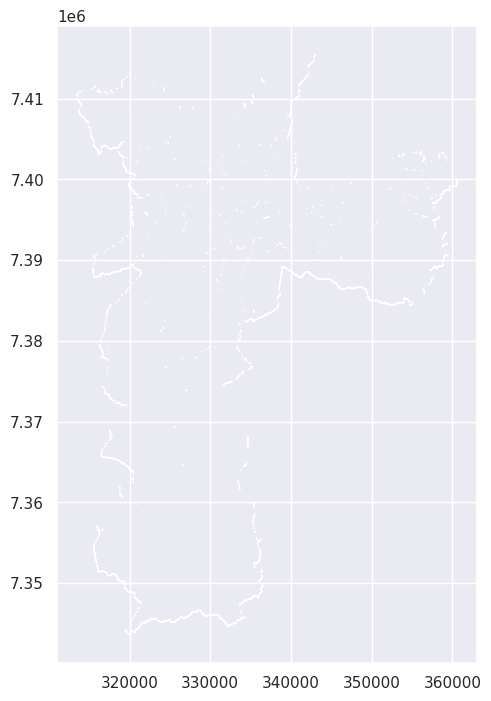

In [28]:
diferenca = distritos10.overlay(distritos22, how='difference')
diferenca.plot()

In [29]:
diferenca.geometry.area.max()

23211.461281901018

In [30]:
diferenca['area'] = diferenca.geometry.area
diferenca = diferenca.sort_values('area', ascending=False)
diferenca

,ID,CD_GEOCODD,NM_DISTRIT,geometry,area
31,4491,355030833,IGUATEMI,"MULTIPOLYGON (((355031.568 7384493.912, 355020...",2.321146e+04
52,4516,355030858,PEDREIRA,"MULTIPOLYGON (((332394.910 7378616.326, 332401...",1.436260e+04
23,4483,355030825,CIDADE TIRADENTES,"MULTIPOLYGON (((357437.586 7387598.403, 357421...",5.125604e+03
33,4494,355030836,ITAIM PAULISTA,"MULTIPOLYGON (((357381.135 7397635.182, 357381...",3.536199e+02
15,4475,355030817,CAMPO LIMPO,"MULTIPOLYGON (((320369.392 7387173.643, 320372...",2.665485e+02
...,...,...,...,...,...
45,4509,355030851,MANDAQUI,"MULTIPOLYGON (((334371.856 7402486.536, 334371...",1.639394e-10
14,4474,355030816,CAMPO GRANDE,"MULTIPOLYGON (((329548.687 7379052.610, 329548...",1.243139e-10
7,4467,355030809,BOM RETIRO,"MULTIPOLYGON (((333961.435 7396024.127, 333961...",2.901178e-11
76,4544,355030886,VILA GUILHERME,"POLYGON ((336941.354 7400522.245, 336941.354 7...",2.023414e-14


Dado que alguns distritos apresentaram diferenças, vamos definir uma tolerância (em metros quadrados) para avaliarmos visualmente.

In [31]:
tolerancia_distritos = 5**2

<Axes: >

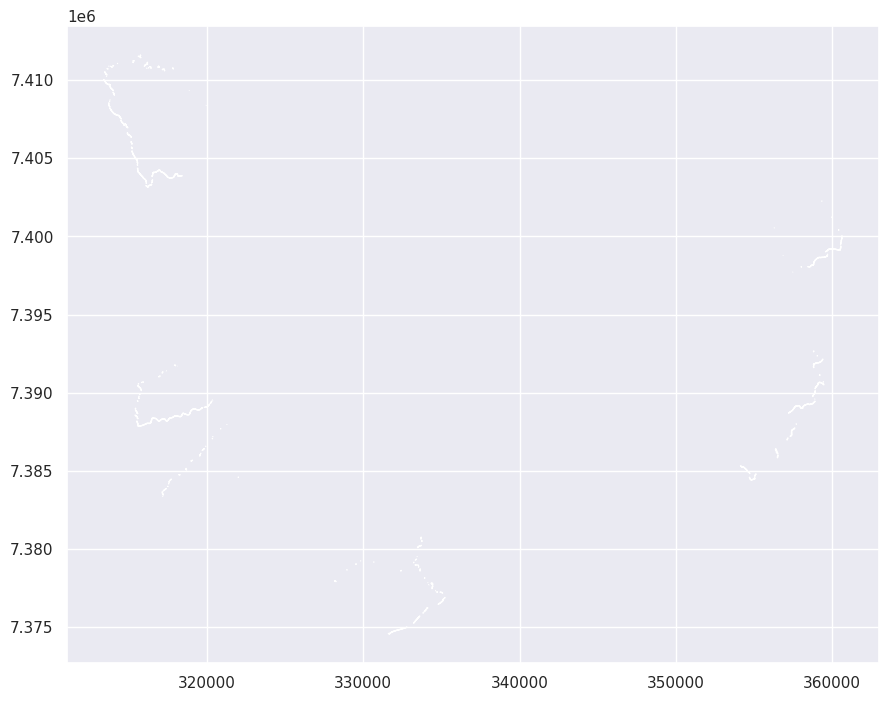

In [32]:
diferenca[diferenca.geometry.area > tolerancia_distritos].plot()

In [33]:
diferenca[diferenca.geometry.area > tolerancia_distritos].shape

(8, 5)

Apenas 8 distritos apresentaram diferenças maiores do que a tolerância atual. Vamos avaliá-los visualmente.

In [34]:
distritos_diferentes = diferenca.loc[diferenca.geometry.area > tolerancia_distritos, 'CD_GEOCODD'].tolist()
distritos_diferentes

['355030833',
 '355030858',
 '355030825',
 '355030836',
 '355030817',
 '355030865',
 '355030803',
 '355030822']

In [35]:
mapa_distritos = distritos10[distritos10['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_distritos = distritos22[distritos22['CD_DIST'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_distritos = diferenca[diferenca['CD_GEOCODD'].isin(distritos_diferentes)].explore(
    m=mapa_distritos,
    name='Diferença',  # name of the layer in the map
    color='purple',
)

folium.LayerControl().add_to(mapa_distritos)  # use folium to add layer control

mapa_distritos

A inspeção visual indica que os distritos se mantiveram os mesmos, com diferenças apenas quanto a ajustes pontuais nos desenhos dos polígonos de distritos de fronteira. Para confirmar, podemos avaliar a interseção entre os distritos para confirmação.

## Proporcionalidade das geometrias


Temos 2 formas de entender as relações entre as geometrias dos dois censos. Para exemplificar, vamos supor 1 geometria (A) do censo mais recente e 2 geometrias (B e C) do censo mais antigo, sendo que A está contido em B e C, mas B e C não estão contidos em A.

Uma forma é a composição da geometria A em relação às geometrias B e C, ou seja, quanto as interseções A∩B e A∩C representam de A. Essa composição é interessante para compreendermos o setor A e os valores inferidos para ele.

A outra forma é quanto a interção A∩B representa de B e quanto a interseção A∩C representa de C. Essa forma é a que precisamos para inferirmos os valores de A no censo mais antigo, já que para o censo mais antigo possuímos apenas os valores de B e C.

As próximas seções buscam calcular essas duas formas.

### 2022 em relação a 2022

In [36]:
calc_similarity(
    distritos22.iloc[0],
    distritos10[['CD_GEOCODD', 'geometry']],
    left_key_col='CD_DIST',
    right_key_col='CD_GEOCODD'
).sort_values('inter_perc', ascending=False)

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
830,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
922,355030801,355030893,"MULTIPOLYGON (((338734.574 7392064.455, 338742...",3.641472e+01,5.104596e-06
914,355030801,355030885,"MULTIPOLYGON (((339863.899 7394315.579, 339863...",1.591402e+01,2.230819e-06
909,355030801,355030880,"MULTIPOLYGON (((339863.899 7394315.579, 339857...",7.737985e+00,1.084707e-06
837,355030801,355030808,"MULTIPOLYGON (((338845.896 7394783.596, 338843...",1.509633e+00,2.116195e-07
901,355030801,355030872,"MULTIPOLYGON (((340738.300 7391308.855, 340785...",9.423723e-01,1.321013e-07
882,355030801,355030853,"MULTIPOLYGON (((338359.502 7394255.270, 338359...",7.343813e-01,1.029452e-07


In [37]:
calc_similarity(
    distritos22.iloc[0],
    distritos10[['CD_GEOCODD', 'geometry']],
    left_key_col='CD_DIST',
    right_key_col='CD_GEOCODD',
    method='difference'
).sort_values('inter_perc', ascending=False)

,CD_DIST,CD_GEOCODD,geometry,inter_perc
830,355030801,355030801,"MULTIPOLYGON (((339574.359 7391448.732, 339568...",9.999911e-01
922,355030801,355030893,"POLYGON ((339582.103 7391446.606, 339582.064 7...",5.104596e-06
914,355030801,355030885,"POLYGON ((341140.297 7392048.604, 341110.792 7...",2.230819e-06
909,355030801,355030880,"POLYGON ((339866.158 7394310.711, 339866.012 7...",1.084707e-06
837,355030801,355030808,"POLYGON ((338845.896 7394783.596, 338860.420 7...",2.116195e-07
...,...,...,...,...
860,355030801,355030831,"POLYGON ((339568.672 7391450.324, 339556.505 7...",5.551115e-16
859,355030801,355030830,"POLYGON ((339568.672 7391450.324, 339556.505 7...",5.551115e-16
858,355030801,355030829,"POLYGON ((339568.672 7391450.324, 339556.505 7...",5.551115e-16
857,355030801,355030828,"POLYGON ((339568.672 7391450.324, 339556.505 7...",5.551115e-16


In [38]:
%%time
simd_22_path = 'data/01_similarity_distritos.parquet'
if exists(simd_22_path):
    simd_22 = gpd.read_parquet(simd_22_path)
else:
    simd_22 = calc_similarity(distritos22, distritos10[['CD_GEOCODD', 'geometry']], left_key_col='CD_DIST', right_key_col='CD_GEOCODD')
simd_22

CPU times: user 58.1 ms, sys: 5.31 ms, total: 63.4 ms
Wall time: 496 ms


,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
0,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
1,355030801,355030808,"MULTIPOLYGON (((338506.784 7394407.405, 338474...",1.509633e+00,2.116195e-07
2,355030801,355030853,"MULTIPOLYGON (((338632.189 7392360.025, 338630...",7.343813e-01,1.029452e-07
3,355030801,355030872,"MULTIPOLYGON (((340785.840 7391321.063, 340715...",9.423723e-01,1.321013e-07
4,355030801,355030880,"MULTIPOLYGON (((339841.931 7394332.042, 339838...",7.737985e+00,1.084707e-06
...,...,...,...,...,...
519,355030896,355030837,"POLYGON ((353934.990 7397136.425, 353943.249 7...",9.582123e+00,1.076639e-06
520,355030896,355030847,"MULTIPOLYGON (((354742.838 7396048.156, 354742...",6.337849e-01,7.121156e-08
521,355030896,355030874,"MULTIPOLYGON (((353878.469 7397729.127, 353870...",1.939974e-02,2.179739e-09
522,355030896,355030884,"MULTIPOLYGON (((356892.488 7397357.441, 356879...",4.326556e+00,4.861283e-07


Por definção, a soma do percentual de todas as interseções de um dado distrito em 2022 devem ser 1.

In [39]:
soma_22 = simd_22[['CD_DIST','inter_perc']].groupby('CD_DIST').sum()
soma_22.value_counts().sort_index()

inter_perc
0.994035      1
0.998680      1
0.999793      1
0.999991      1
0.999991      1
             ..
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
Name: count, Length: 96, dtype: int64


Apesar de alguns casos onde a interseção aparece com valores pouco menores do que 1, isso provavelmente se deve a erros de arredondamento no cálculo da área, já que não existe nenhuma interseção com valores próximos a 0.

Outro fator pode ser ajustes nas bordas do município, mas de todo modo não são casos relevantes, visto que o distrito com a menor soma tem 99,4% de similaridade total.

Agora, vejamos se existe algum distrito de 2022 com interseção com mais de um distrito de 2010.

In [40]:
count_22 = simd_22[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_22.value_counts()

CD_GEOCODD
6             25
4             20
5             20
7             15
3              7
8              6
9              2
2              1
Name: count, dtype: int64


Nenhum distrito de 2022 apresentou interseção com apenas um distrito de 2010, diferente do que que se esperava. Isso indica que provavelmente existem interseções não significativas nas bordas dos distritos, devidos a ajustes dos polígonos sobre a malha viária ou outras divisas, mas não relacionadas a áreas com população alvo.

Vamos checar se todas as geometrias são compostas apenas por polígonos.

In [41]:
simd_22['geometry'].type.value_counts()

MultiPolygon    341
Polygon         183
Name: count, dtype: int64

Dez geometrias contém pontos ou linhas. Vamos removê-las antes de continuar a análise.

In [42]:
simd_22 = simd_22.explode()
simd_22 = simd_22[simd_22['geometry'].type=='Polygon']
simd_22 = simd_22.dissolve(['CD_DIST', 'CD_GEOCODD']).reset_index()
simd_22

/tmp/ipykernel_514356/1408795312.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  simd_22 = simd_22.explode()


,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
0,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
1,355030801,355030808,"MULTIPOLYGON (((338459.532 7394359.372, 338425...",1.509633e+00,2.116195e-07
2,355030801,355030853,"MULTIPOLYGON (((338628.274 7392317.010, 338615...",7.343813e-01,1.029452e-07
3,355030801,355030872,"MULTIPOLYGON (((340715.262 7391302.900, 340738...",9.423723e-01,1.321013e-07
4,355030801,355030880,"MULTIPOLYGON (((339829.497 7394339.437, 339815...",7.737985e+00,1.084707e-06
...,...,...,...,...,...
519,355030896,355030837,"POLYGON ((353934.990 7397136.425, 353943.249 7...",9.582123e+00,1.076639e-06
520,355030896,355030847,"MULTIPOLYGON (((354742.886 7396048.250, 354742...",6.337849e-01,7.121156e-08
521,355030896,355030874,"MULTIPOLYGON (((353870.622 7397717.310, 353869...",1.939974e-02,2.179739e-09
522,355030896,355030884,"MULTIPOLYGON (((356869.295 7397338.057, 356862...",4.326556e+00,4.861283e-07


In [43]:
simd_22['geometry'].type.value_counts()

MultiPolygon    341
Polygon         183
Name: count, dtype: int64

Por último, vamos inspecionar visualmente alguns distritos.

In [44]:
sample_id = distritos22['CD_DIST'].sample(5)
sample = simd_22[simd_22['CD_DIST'].isin(sample_id)]
sample

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
0,355030801,355030801,"POLYGON ((338561.902 7394464.275, 338564.830 7...",7.133649e+06,9.999911e-01
1,355030801,355030808,"MULTIPOLYGON (((338459.532 7394359.372, 338425...",1.509633e+00,2.116195e-07
2,355030801,355030853,"MULTIPOLYGON (((338628.274 7392317.010, 338615...",7.343813e-01,1.029452e-07
3,355030801,355030872,"MULTIPOLYGON (((340715.262 7391302.900, 340738...",9.423723e-01,1.321013e-07
4,355030801,355030880,"MULTIPOLYGON (((339829.497 7394339.437, 339815...",7.737985e+00,1.084707e-06
5,355030801,355030885,"MULTIPOLYGON (((341189.318 7392168.745, 341199...",1.591402e+01,2.230819e-06
6,355030801,355030893,"MULTIPOLYGON (((339665.865 7391427.447, 339582...",3.641472e+01,5.104596e-06
80,355030814,355030810,"MULTIPOLYGON (((335561.946 7394169.604, 335428...",8.153424e+01,2.073497e-05
81,355030814,355030814,"POLYGON ((334103.793 7394251.924, 334111.777 7...",3.932006e+06,9.999486e-01
82,355030814,355030834,"MULTIPOLYGON (((334827.172 7391591.104, 334869...",5.853863e+00,1.488696e-06


In [45]:
mapa_inter = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter = sample.query("inter_perc > 0.01").explore(
    m=mapa_inter,
    name='Interseções com similaridade > 1%',  # name of the layer in the map
    color='purple',
)
mapa_inter = sample.query("inter_perc <= 0.01").explore(
    m=mapa_inter,
    name='Interseções com similaridade <= 1%',  # name of the layer in the map
    color='limegreen',
)

folium.LayerControl().add_to(mapa_inter)  # use folium to add layer control

mapa_inter

A análise visual indica que, de fato, os distritos não tiveram modificação.

In [46]:
simd_22.to_parquet(simd_22_path)

### 2022 em relação a 2010

Invertendo a ordem dos dataframes na função para a comparação, temos o quanto as interseções representam em relação aos distritos de 2010. O esperado é que todos os valores sejam 1.0 novamente.

In [47]:
%%time
simd_10 = calc_similarity(distritos10, distritos22[['CD_DIST', 'geometry']], left_key_col='CD_GEOCODD', right_key_col='CD_DIST')
simd_10

CPU times: user 473 ms, sys: 7.84 ms, total: 481 ms
Wall time: 480 ms


,CD_GEOCODD,CD_DIST,geometry,inter_area,inter_perc
831,355030801,355030801,"POLYGON ((339582.103 7391446.606, 339582.064 7...",7.133649e+06,9.999929e-01
838,355030801,355030808,"MULTIPOLYGON (((338561.801 7394464.163, 338558...",1.079318e+01,1.512985e-06
883,355030801,355030853,"MULTIPOLYGON (((338572.344 7392223.474, 338574...",7.409268e+00,1.038629e-06
902,355030801,355030872,"MULTIPOLYGON (((340822.866 7391329.199, 340830...",5.815371e+00,8.151970e-07
910,355030801,355030880,"MULTIPOLYGON (((338933.568 7394599.604, 338921...",1.746004e+00,2.447544e-07
...,...,...,...,...,...
867,355030896,355030837,"MULTIPOLYGON (((353969.877 7397061.711, 353983...",3.094854e-02,3.477360e-09
877,355030896,355030847,"MULTIPOLYGON (((354734.182 7396031.105, 354734...",1.554163e-01,1.746248e-08
904,355030896,355030874,"POLYGON ((353886.389 7397732.302, 353886.402 7...",5.317335e-02,5.974527e-09
914,355030896,355030884,"MULTIPOLYGON (((354805.847 7398051.652, 354783...",6.438261e-01,7.233992e-08


In [48]:
soma_10 = simd_10[['CD_GEOCODD','inter_perc']].groupby('CD_GEOCODD').sum()
soma_10.value_counts().sort_index()

inter_perc
0.998808      1
0.999222      1
0.999656      1
0.999971      1
0.999979      1
             ..
1.000000      1
1.000000      1
1.000000      1
1.000000      1
1.000000      1
Name: count, Length: 89, dtype: int64

Novamente, alguns valores pouco menores do que 1.0, mas nenhum valor próximo a 0, o que indica erros de arredondamento.

In [49]:
count_10 = simd_10[['CD_DIST','CD_GEOCODD']].groupby('CD_DIST').count()
count_10.value_counts()

CD_GEOCODD
6             25
4             20
5             20
7             15
3              7
8              6
9              2
2              1
Name: count, dtype: int64

Apenas dois distritos de 2022 apresentaram interseção com apenas um distrito de 2010. Isso reforça o indicativo de que provavelmente existem interseções não significativas nas bordas dos distritos, devidos a ajustes dos polígonos sobre a malha viária ou outras divisas, mas não relacionadas a áreas com população alvo.

Vamos checar se todas as geometrias são compostas apenas por polígonos.

In [50]:
simd_10['geometry'].type.value_counts()

MultiPolygon          331
Polygon               183
GeometryCollection     10
Name: count, dtype: int64

Dez geometrias contém pontos ou linhas. Vamos removê-las antes de continuar a análise.

In [51]:
simd_10 = simd_10.explode()
simd_10 = simd_10[simd_10['geometry'].type=='Polygon']
simd_10 = simd_10.dissolve(['CD_DIST', 'CD_GEOCODD']).reset_index()
simd_10

/tmp/ipykernel_514356/2722978116.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  simd_10 = simd_10.explode()


,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
0,355030801,355030801,"POLYGON ((339582.103 7391446.606, 339582.064 7...",7.133649e+06,9.999929e-01
1,355030801,355030808,"MULTIPOLYGON (((338425.407 7394324.552, 338431...",1.509633e+00,2.466458e-07
2,355030801,355030853,"MULTIPOLYGON (((338628.274 7392317.011, 338630...",7.343813e-01,9.262022e-08
3,355030801,355030872,"MULTIPOLYGON (((340738.300 7391308.855, 340785...",9.423723e-01,9.751774e-08
4,355030801,355030880,"MULTIPOLYGON (((339802.807 7394380.565, 339805...",7.737985e+00,9.117293e-07
...,...,...,...,...,...
519,355030896,355030837,"POLYGON ((353943.267 7397119.032, 353934.990 7...",9.582123e+00,6.520510e-07
520,355030896,355030847,"MULTIPOLYGON (((354742.886 7396048.249, 354742...",6.337849e-01,4.397170e-08
521,355030896,355030874,"MULTIPOLYGON (((353784.108 7397494.631, 353788...",1.939974e-02,2.241071e-09
522,355030896,355030884,"MULTIPOLYGON (((355631.387 7397724.688, 355694...",4.326556e+00,4.554640e-07


In [52]:
simd_10['geometry'].type.value_counts()

MultiPolygon    341
Polygon         183
Name: count, dtype: int64

Finalmente, uma nova inspeção visual, mas dessa vez com a interseção baseada na geometria de 2010.

In [53]:
sample = simd_10.sample(5)
sample

,CD_DIST,CD_GEOCODD,geometry,inter_area,inter_perc
308,355030856,355030809,"MULTIPOLYGON (((334098.172 7396428.925, 334098...",0.036194,8.489097e-09
104,355030819,355030817,"MULTIPOLYGON (((318663.104 7383379.085, 318710...",0.414219,3.292686e-08
28,355030805,355030891,"MULTIPOLYGON (((346684.012 7394921.968, 346694...",9.029118,1.014884e-06
486,355030890,355030814,"POLYGON ((334194.213 7391523.908, 334284.536 7...",11.659719,2.965103e-06
403,355030874,355030884,"MULTIPOLYGON (((353951.667 7397782.127, 353955...",0.597965,6.294877e-08


In [54]:
mapa_inter_2 = distritos10[distritos10['CD_GEOCODD'].isin(sample['CD_GEOCODD'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
)
mapa_inter_2 = distritos22[distritos22['CD_DIST'].isin(sample['CD_DIST'].unique())].explore(
    m=mapa_inter_2,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
)
mapa_inter_2 = sample.query("inter_perc > 0.01").explore(
    m=mapa_inter_2,
    name='Interseções com similaridade > 1%',  # name of the layer in the map
    color='purple',
)
mapa_inter_2 = sample.query("inter_perc <= 0.01").explore(
    m=mapa_inter_2,
    name='Interseções com similaridade <= 1%',  # name of the layer in the map
    color='limegreen',
)

folium.LayerControl().add_to(mapa_inter_2)  # use folium to add layer control

mapa_inter_2

AssertionError: The field CD_DIST is not available in the data. Choose from: ().


Tanto a análise de 2010 em relação a 2022, quanto a análise de 2022 em relação a 2010, indicam que os distritos se mantiveram iguais entre os censos, porém com poucos ajustes nas fronteiras, provavelmente buscando uma melhor representação da geometria, mas sem alterações nas áreas mapeadas.

Entretanto, a análise espacial atual encontra múltiplas interseções não significantes, indicando a necessidade de algum ajuste no algoritmo para melhorar a qualidade da inferência.

# Setores censitários

In [55]:
setores10 = download_malha(Censo.CENSO_2010, Nivel.SETORES, filtro='CD_GEOCODM == "3550308"')
setores10.sample(3)

INFO:root:Baixando a malha de setores do censo de 2010 de https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/sp/sp_setores_censitarios.zip.


,ID,CD_GEOCODI,TIPO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,CD_GEOCODB,NM_BAIRRO,ID1,geometry
44881,110463.0,355030813000018,URBANO,35503081300,None,355030813,CACHOEIRINHA,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,44882,"POLYGON ((-46.65843 -23.46330, -46.65883 -23.4..."
60055,125623.0,355030884000051,URBANO,35503088400,None,355030884,VILA CURUÇÁ,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,60056,"POLYGON ((-46.41688 -23.51834, -46.41703 -23.5..."
52709,118291.0,355030846000029,URBANO,35503084600,None,355030846,JARDIM SÃO LUÍS,3550308,SÃO PAULO,SÃO PAULO,METROPOLITANA DE SÃO PAULO,None,None,52710,"POLYGON ((-46.74928 -23.67498, -46.74956 -23.6..."


In [56]:
setores22 = download_malha(Censo.CENSO_2022, Nivel.SETORES, filtro='CD_MUN == "3550308"')
setores22.sample(3)

INFO:root:Baixando a malha de setores do censo de 2022 de https://ftp.ibge.gov.br/Censos/Censo_Demografico_2022/Agregados_por_Setores_Censitarios_preliminares/malha_com_atributos/setores/json/UF/SP/SP_Malha_Preliminar_2022.zip.


,CD_SETOR,AREA_KM2,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,...,CD_CONCURB,NM_CONCURB,v0001,v0002,v0003,v0004,v0005,v0006,v0007,geometry
66675,355030806000072P,0.012655,3,Sudeste,35,São Paulo,3550308,São Paulo,355030806,Barra Funda,...,3550308,São Paulo/SP,294,156,156,0,2.130435,0.724638,138,"POLYGON ((-46.66393 -23.53096, -46.66408 -23.5..."
82430,355030858000191P,0.007180,3,Sudeste,35,São Paulo,3550308,São Paulo,355030858,Pedreira,...,3550308,São Paulo/SP,491,181,181,0,2.888235,23.529412,170,"POLYGON ((-46.64030 -23.69699, -46.64041 -23.6..."
77824,355030842000377P,0.010811,3,Sudeste,35,São Paulo,3550308,São Paulo,355030842,Jaraguá,...,3550308,São Paulo/SP,533,219,219,0,2.790576,19.895288,191,"POLYGON ((-46.72198 -23.44760, -46.72201 -23.4..."


## Proporcionalidade das geometrias

### Ajustando o CRS

In [57]:
setores10 = setores10.to_crs('EPSG:31983')
setores22 = setores22.to_crs('EPSG:31983')

### 2022 em relação a 2022

In [58]:
calc_similarity(setores22.iloc[0], setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI')

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,0.988099
43405,355030801000001P,355030801000006,"MULTIPOLYGON (((339630.241 7392594.043, 339628...",373.279509,0.005200
43409,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,0.000129
43410,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,0.006572


In [59]:
%%time
%%time
sims_22_path = 'data/01_similarity.parquet'
if exists(sims_22_path):
    sims_22 = gpd.read_parquet(sims_22_path)
else:
    sims_22 = calc_similarity(setores22, setores10, left_key_col='CD_SETOR', right_key_col='CD_GEOCODI')
sims_22

CPU times: user 16min 42s, sys: 1.18 s, total: 16min 43s
Wall time: 16min 44s
CPU times: user 16min 42s, sys: 1.18 s, total: 16min 43s
Wall time: 16min 44s


,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
43400,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,9.880993e-01
43405,355030801000001P,355030801000006,"MULTIPOLYGON (((339630.241 7392594.043, 339628...",373.279509,5.199974e-03
43409,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,1.287275e-04
43410,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,6.572010e-03
43400,355030801000002P,355030801000001,"POLYGON ((339814.260 7392989.900, 339811.966 7...",18.451154,2.566574e-04
...,...,...,...,...,...
62241,355030896000338P,355030896000104,"POLYGON ((355756.807 7397691.040, 355771.483 7...",33668.997801,9.873096e-01
60168,355030896000339P,355030884000164,"POLYGON ((355953.783 7397535.061, 355931.532 7...",0.003980,3.971344e-07
61678,355030896000339P,355030896000044,"MULTIPOLYGON (((355952.348 7397493.652, 355945...",2.775304,2.769267e-04
62240,355030896000339P,355030896000103,"MULTIPOLYGON (((355573.427 7397636.444, 355567...",6952.030517,6.936909e-01


Vamos checar se todas as geometrias são compostas apenas por polígonos.

In [60]:
sims_22['geometry'].type.value_counts()

Polygon               87876
MultiPolygon          19371
GeometryCollection     7154
Name: count, dtype: int64

Algumas geometrias contém pontos ou linhas. Vamos removê-las antes de continuar a análise.

In [62]:
sims_22 = sims_22.explode()
sims_22 = sims_22[sims_22['geometry'].type=='Polygon']
sims_22 = sims_22.dissolve(['CD_SETOR', 'CD_GEOCODI']).reset_index()
sims_22

/tmp/ipykernel_514356/8758739.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sims_22 = sims_22.explode()


,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
0,355030801000001P,355030801000001,"POLYGON ((339784.892 7392592.542, 339764.035 7...",70930.590833,9.880993e-01
1,355030801000001P,355030801000006,"MULTIPOLYGON (((339819.409 7392592.743, 339784...",373.279509,5.199974e-03
2,355030801000001P,355030801000010,"POLYGON ((339617.259 7392754.613, 339531.109 7...",9.240690,1.287275e-04
3,355030801000001P,355030801000011,"POLYGON ((339777.790 7392945.533, 339661.597 7...",471.770933,6.572010e-03
4,355030801000002P,355030801000001,"POLYGON ((339814.260 7392989.900, 339811.966 7...",18.451154,2.566574e-04
...,...,...,...,...,...
114396,355030896000338P,355030896000104,"POLYGON ((355756.807 7397691.040, 355771.483 7...",33668.997801,9.873096e-01
114397,355030896000339P,355030884000164,"POLYGON ((355953.783 7397535.061, 355931.532 7...",0.003980,3.971344e-07
114398,355030896000339P,355030896000044,"MULTIPOLYGON (((355945.903 7397487.853, 355937...",2.775304,2.769267e-04
114399,355030896000339P,355030896000103,"MULTIPOLYGON (((355820.955 7397537.877, 355825...",6952.030517,6.936909e-01


In [63]:
sims_22['geometry'].type.value_counts()

Polygon         91158
MultiPolygon    23243
Name: count, dtype: int64

In [64]:
sims_22.to_parquet(sims_22_path)

In [65]:
sims_22.shape[0]/setores22.shape[0]

4.146165555233401

A análise geométrica indica uma média de aproximadamente 4,1 interseções por setor censitário de 2022, o que parece acima do razoável e, provavelmente, contém uma série de falsos positivos.

Vamos avaliar em mais detalhes a base de dados resultante e depois avaliar visualmente alguns setores.

#### Resultados gerais

Além da média, vamos avaliar a distribuição de interseções por setor censitário de 2022.

In [66]:
counts_22 = sims_22[['CD_SETOR', 'CD_GEOCODI']].groupby('CD_SETOR').count()

counts_22.describe()

,CD_GEOCODI
count,27592.000000
mean,4.146166
std,1.957557
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,55.000000


A distribuição possui média e mediana bem próximas, o que indica que tende a ser simétrica. Entretanto, possui outliers na cauda direita, indicado pela média pouco acima da mediana e grande diferença entre Q3 e máximo. Vamos remover os outliers e avaliar o histrograma da distribuição.

<Axes: ylabel='Count'>

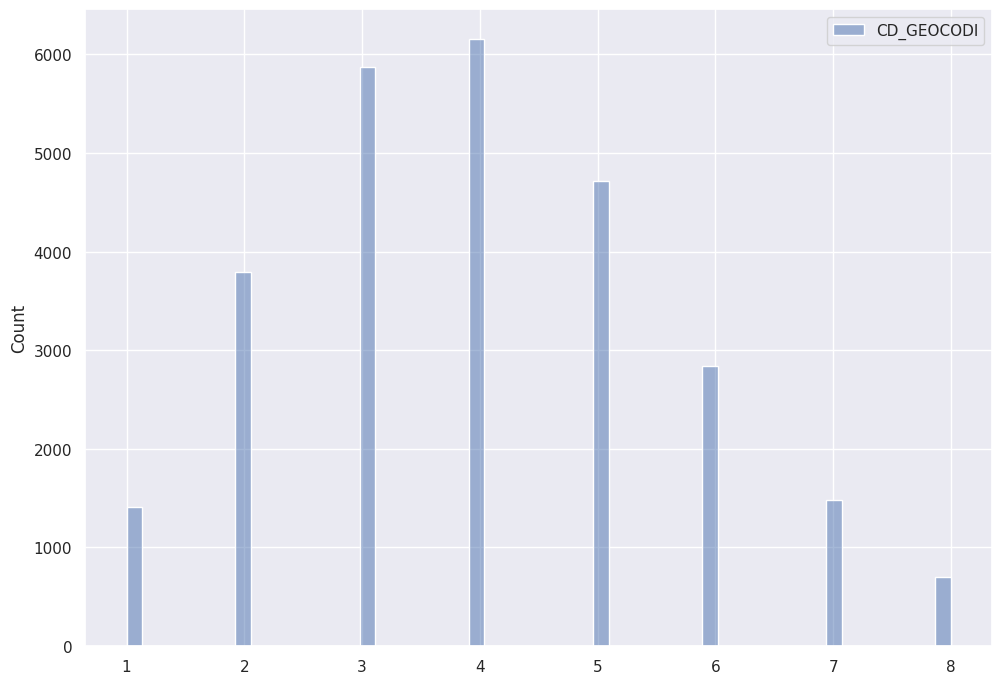

In [67]:
aiqs = counts_22['CD_GEOCODI'].quantile(0.75)-counts_22['CD_GEOCODI'].quantile(0.25)
limite_superiors = counts_22['CD_GEOCODI'].quantile(0.75)+1.5*aiqs

sns.histplot(counts_22.query(f'CD_GEOCODI <= {limite_superiors}'))

In [68]:
counts_22.query(f'CD_GEOCODI <= {limite_superiors}').describe()

,CD_GEOCODI
count,26963.000000
mean,3.997701
std,1.660038
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,8.000000


De fato, mesmo removendo os outliers, temos a maior parte do setores censitários possuindo 4 ou mais interseções, o que parece acima do esperado. Vamos avaliar os percentuais de interseção entre os setores.

In [69]:
sims_22[['inter_perc']].describe()

,inter_perc
count,1.144010e+05
mean,2.411826e-01
std,4.008097e-01
min,1.286861e-25
25%,3.020854e-07
50%,6.843529e-04
75%,3.396242e-01
max,1.000000e+00


A média está bem acima da mediana, então esperamos uma distribuição assimétrica à direita, mas dessa vez por uma quantidade elevada de valores abaixo do esperado. Isso porque a distribuição desta vez é limitada à esquerda e à direita, de modo que dificilmente outliers nos limites distorçam a média.

Além disso, vemos que a maior parte da distribuição está bem abaixo de 1% (já que a mediana é igual a 0.0006843529), o que corrobora com a espectativa de interseções devidas a ajustes das geometrias, mas sem impacto real nas populações alvo desses setores.

Como esse intervalo é limitado nos dois lados, não precisamos remover os outliers para avaliar a distribuição.

<Axes: xlabel='inter_perc', ylabel='Probability'>

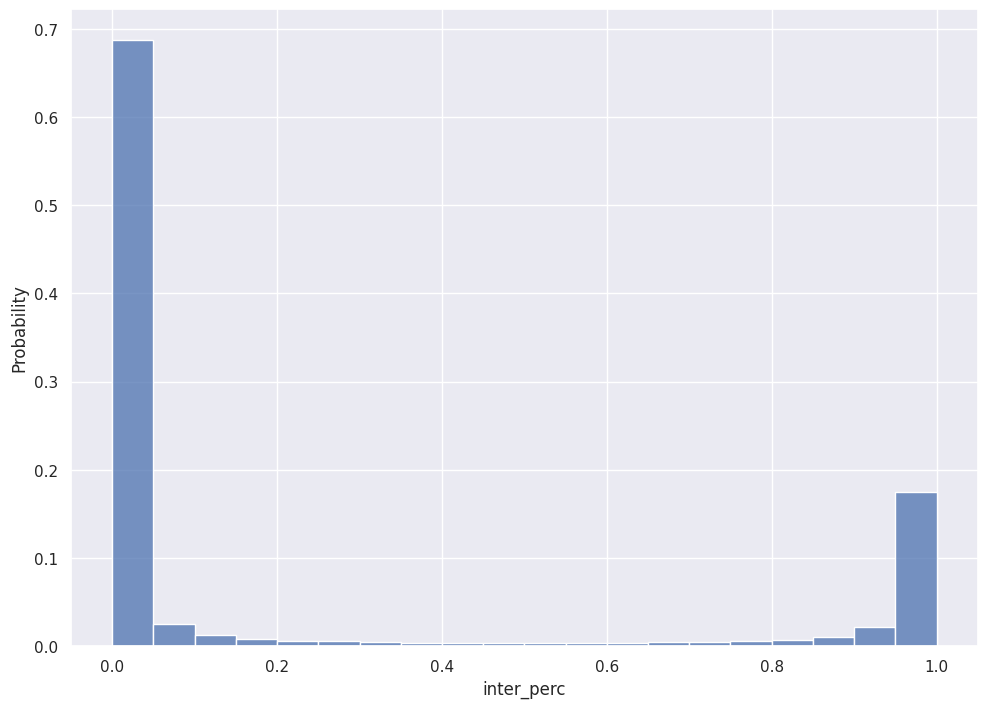

In [70]:
sns.histplot(sims_22['inter_perc'], bins=20, stat='probability')

Conforme esperado, temos uma quandidade bastante elevada de interseções ($\approx$70%) com área menor do que 5% do setor censitário de 2022. 

#### Inspeção visual

In [71]:
sample_ids = sims_22['CD_SETOR'].drop_duplicates().sample(100)
samples_22 = sims_22[sims_22['CD_SETOR'].isin(sample_ids)]
samples_22

,CD_SETOR,CD_GEOCODI,geometry,inter_area,inter_perc
259,355030801000063P,355030801000033,"POLYGON ((340171.137 7393384.307, 340180.440 7...",400.948800,6.352537e-03
260,355030801000063P,355030801000034,"POLYGON ((340297.594 7393275.161, 340400.851 7...",579.544015,9.182157e-03
261,355030801000063P,355030801000062,"MULTIPOLYGON (((339998.060 7393536.688, 339998...",408.993718,6.479999e-03
262,355030801000063P,355030801000063,"POLYGON ((340400.851 7393214.933, 340297.594 7...",61273.575567,9.708039e-01
263,355030801000063P,355030801000064,"MULTIPOLYGON (((340168.163 7393383.736, 340078...",453.219366,7.180699e-03
...,...,...,...,...,...
112184,355030895000037P,355030895000098,"MULTIPOLYGON (((322221.705 7400905.414, 322221...",0.030782,4.744688e-07
112691,355030895000208P,355030895000068,"POLYGON ((320143.739 7402326.715, 320126.154 7...",30832.122816,7.785331e-01
112692,355030895000208P,355030895000109,"POLYGON ((320007.656 7402368.355, 320038.193 7...",8770.718291,2.214669e-01
113560,355030896000137P,355030896000136,"POLYGON ((357871.156 7396036.870, 357847.689 7...",0.006987,1.646902e-07


Com todas as geometrias como polígonos (ou multi-polígonos), podemos avaliar visualmente.

In [74]:
mapa_inter_setor = setores10[setores10['CD_GEOCODI'].isin(samples_22['CD_GEOCODI'].unique())].explore(
    name='Distritos (2010)',  # name of the layer in the map
    color='darkred',
    # style_kwds={'fill': False},
)
mapa_inter_setor = setores22[setores22['CD_SETOR'].isin(samples_22['CD_SETOR'].unique())].explore(
    m=mapa_inter_setor,
    name='Distritos (2022)',  # name of the layer in the map
    color='royalblue',
    # style_kwds={'fill': False},
)
mapa_inter_setor = samples_22.query("inter_perc > 0.01").explore(
    m=mapa_inter_setor,
    name='Interseções com similaridade > 1%',  # name of the layer in the map
    color='purple',
)
mapa_inter_setor = samples_22.query("inter_perc <= 0.01").explore(
    m=mapa_inter_setor,
    name='Interseções com similaridade <= 1%',  # name of the layer in the map
    color='limegreen',
)

folium.LayerControl().add_to(mapa_inter_setor)  # use folium to add layer control

mapa_inter_setor